In [1]:
import pandas as pd
import re
import missingno as msno

In [2]:
# Read the csv file
df = pd.read_csv('C:\Language_Projects\Language_Projects\Python\Flagship_1\\automotive_diagnostic_data_cleaning\data\Pre-Screen_Test_Results.csv')

<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:2: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2771380963.py:2: SyntaxWarning: invalid escape sequence '\L'
  df = pd.read_csv('C:\Language_Projects\Language_Projects\Python\Flagship_1\\automotive_diagnostic_data_cleaning\data\Pre-Screen_Test_Results.csv')


In [3]:
# Print the info of the extracted column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8395 entries, 0 to 8394
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Created Time  8395 non-null   object 
 1   H Number      8395 non-null   object 
 2   Entry Type    8395 non-null   object 
 3   Technician    8335 non-null   object 
 4   Source        8395 non-null   object 
 5   Year          8394 non-null   float64
 6   Make          8395 non-null   object 
 7   Model         8393 non-null   object 
 8   Engine Size   8162 non-null   object 
 9   HW #          7363 non-null   object 
 10  Part #        7950 non-null   object 
 11  Notes         8348 non-null   object 
dtypes: float64(1), object(11)
memory usage: 787.2+ KB


In [4]:
# As the entry type 'RMA Test Results' does not contain prescreen notes, the rows with this entry type will be removed
df['Entry Type'].value_counts()

Entry Type
Pre-Screen Form Completed    5044
RMA Pre-Screen               1762
RMA Test Results             1589
Name: count, dtype: int64

In [5]:
# Filter the DataFrame excluding the entry type 'RMA Test Results'
df_prescreen_notes = df[df['Entry Type'].isin(['RMA Pre-Screen', 'Pre-Screen Form Completed'])]

In [6]:
# Check the df updated
df_prescreen_notes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6806 entries, 0 to 8394
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Created Time  6806 non-null   object 
 1   H Number      6806 non-null   object 
 2   Entry Type    6806 non-null   object 
 3   Technician    6754 non-null   object 
 4   Source        6806 non-null   object 
 5   Year          6806 non-null   float64
 6   Make          6806 non-null   object 
 7   Model         6805 non-null   object 
 8   Engine Size   6615 non-null   object 
 9   HW #          6001 non-null   object 
 10  Part #        6444 non-null   object 
 11  Notes         6760 non-null   object 
dtypes: float64(1), object(11)
memory usage: 691.2+ KB


In [7]:
# Create a dataframe with only the 'Pre-Screen Form Completed' entry type
df_prescreen_zoho_form = df_prescreen_notes[df_prescreen_notes['Entry Type'] == 'Pre-Screen Form Completed']

In [8]:
# Check the df updated
df_prescreen_zoho_form.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5044 entries, 13 to 8394
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Created Time  5044 non-null   object 
 1   H Number      5044 non-null   object 
 2   Entry Type    5044 non-null   object 
 3   Technician    5044 non-null   object 
 4   Source        5044 non-null   object 
 5   Year          5044 non-null   float64
 6   Make          5044 non-null   object 
 7   Model         5043 non-null   object 
 8   Engine Size   4902 non-null   object 
 9   HW #          4472 non-null   object 
 10  Part #        4789 non-null   object 
 11  Notes         5044 non-null   object 
dtypes: float64(1), object(11)
memory usage: 512.3+ KB


The CRM form contains the string 'Additional Notes' and the Entry Type 'Pre-Screen Form Completed' should contains only those accounts prescreened with the CRM form. 

In [9]:
# Confirm if the Entry Type 'Pre-Screen Form Completed' has only accounts prescreened with CRM form by using the string 'Additional Notes'
additional_notes_checking = df_prescreen_zoho_form['Notes'].str.contains('Additional Notes', case=False, na=False)

In [10]:
# Count if there is a False value
additional_notes_checking.value_counts()

Notes
True    5044
Name: count, dtype: int64

### STRUCTURED DATA EXTRACTION FROM NOTES FIELD

The 'Notes' column contains all diagnostic form data (original problems, 
current problems, resolution) in unstructured text format. This process 
extracts and separates these fields into distinct columns to facilitate:

- Diagnostic technician analysis
- Common module problem identification  
- Statistical analysis and reporting
- Pattern recognition in automotive diagnostics

In [11]:
def extract_information(df, pattern, col_name, len_size_col):
    '''Extract data: symptoms, 
    dtcs and strings from column notes'''
    ser_zoho_form_data_extracted = df['Notes'].str.extract(pattern, flags=re.IGNORECASE | re.DOTALL)
    # Rename column from 0 to the related info extracted
    zoho_form_data_extracted_renamed_column = ser_zoho_form_data_extracted.rename(columns={0: col_name})
    # Replace chars, whitespaces and no needed info from the data extracted
    zoho_form_data_extracted_no_chars = zoho_form_data_extracted_renamed_column[col_name].str.replace(r'<[^>]+>|\n|:|=|\?|\\|\/|\r', '', regex=True).str.strip()
    # Update the main df with the extracted data
    df[col_name] = zoho_form_data_extracted_no_chars
        
    '''Method to create a list with the data extracted to check if the field names were not included in the extraction'''
    # List with the string sizes
    string_size_list = []

    # Loop to iterate under the original problems column
    for string in df[col_name]:
        # Count the strings' length
        string_length = len(string)
        # Append the length to the list
        string_size_list.append(string_length)

    # Add to the main df a column with length of the data extracted
    df[len_size_col] = string_size_list

    return df

In [12]:
# Small function to get the index with the biggest string lengths
def get_index_w_biggest_len(df, col, str_length):
    # Return the index
    return df[df[col] == str_length].index

In [13]:
# Small function to confirm the content of the string
def string_content(df, col, idx):
    return df[col][idx]

ORIGINAL PROBLEMS EXTRACTION

In [14]:
# Create the pattern to extract the original problems
original_problems_pattern = r'experienced with customers original unit:\s*(.*?)(?=DTCs on original unit)'

In [15]:
# Call the function to extract the original problems
df_original_problems_extracted = extract_information(df_prescreen_zoho_form, original_problems_pattern, 'Original Problems', 'Original Problems Len')

C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = zoho_form_data_extracted_no_chars
C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[len_size_col] = string_size_list


### Checking the content of the biggest string and confirm if the field string were not extracted.

In [16]:
# Show an ascending stat with the original problems string length
df_original_problems_extracted['Original Problems Len'].value_counts()

Original Problems Len
34     233
12     157
15     137
35     125
14     120
      ... 
163      1
237      1
173      1
169      1
185      1
Name: count, Length: 172, dtype: int64

## Samples with the biggest string lengths

In [17]:
# List with the biggest strings
list_w_biggest_strings = []

In [18]:
list_w_biggest_strings.append(get_index_w_biggest_len(df_original_problems_extracted, 'Original Problems Len', 163))

In [19]:
list_w_biggest_strings.append(get_index_w_biggest_len(df_original_problems_extracted, 'Original Problems Len', 237))

In [20]:
list_w_biggest_strings.append(get_index_w_biggest_len(df_original_problems_extracted, 'Original Problems Len', 173))

In [21]:
list_w_biggest_strings.append(get_index_w_biggest_len(df_original_problems_extracted, 'Original Problems Len', 169))

In [22]:
list_w_biggest_strings.append(get_index_w_biggest_len(df_original_problems_extracted, 'Original Problems Len', 185))

In [23]:
# Print the list with the biggest strings appended
list_w_biggest_strings

[Index([3234], dtype='int64'),
 Index([5991], dtype='int64'),
 Index([4736], dtype='int64'),
 Index([6998], dtype='int64'),
 Index([8374], dtype='int64')]

## Check the content of the string to confirm if the form fields were not extracted

In [24]:
string_content(df_original_problems_extracted, 'Original Problems', 5991)

'Air Conditioning System,Evaporative Emissions System,Exhaust Gas Recirculation System,Manifold Absolute Pressure Sensor,O2 Sensors,Check engine light with multiple codes stored, could not pass emissions but did not have any abnormalities'

In [25]:
string_content(df_original_problems_extracted, 'Original Problems', 4736)

"Communication Networks (CAN, CCD, Etc. Specify in notes.),customer states it won't communicate but starts, which doesn't make any sense. Also they mentioned O2 and ABS codes"

In [26]:
string_content(df_original_problems_extracted, 'Original Problems', 6998)

'ImmobilizerSecurity,No start, locksmith replaced PATS module and crank sensor but still no start. Then they tried another PCM, starter with incorect speedometer readings'

In [27]:
string_content(df_original_problems_extracted, 'Original Problems', 8374)

'Communication Networks (CAN, CCD, Etc. Specify in notes.),key will not turn back, gas hand stopped working, AC not working, doors will not auto unlock, rear lights not working, no start'

## Content of the original problems extracted are correct

ORIGINAL DTCs

In [28]:
# Create the pattern to extract the original DTCs
original_dtcs_pattern = r'DTCs on original unit:(.*?)(?=DTCs transcript)'

In [29]:
# Call the function to extract the original dtcs
df_original_dtcs_extracted = extract_information(df_original_problems_extracted, original_dtcs_pattern, 'Original DTCs', 'Orig. DTCs Len')

C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = zoho_form_data_extracted_no_chars
C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[len_size_col] = string_size_list


In [30]:
# Show an ascending stat with the original dtcs string length
df_original_dtcs_extracted['Orig. DTCs Len'].value_counts()

Orig. DTCs Len
5      1180
12     1107
8       341
4       241
2       196
       ... 
117       1
477       1
390       1
200       1
108       1
Name: count, Length: 177, dtype: int64

## Samples with the biggest string lengths: ORIGINAL DTCs

In [31]:
# List with the biggest strings
list_w_biggest_strings_orig_dtcs = []

In [32]:
list_w_biggest_strings_orig_dtcs.append(get_index_w_biggest_len(df_original_dtcs_extracted, 'Orig. DTCs Len', 117))

In [33]:
list_w_biggest_strings_orig_dtcs.append(get_index_w_biggest_len(df_original_dtcs_extracted, 'Orig. DTCs Len', 477))

In [34]:
list_w_biggest_strings_orig_dtcs.append(get_index_w_biggest_len(df_original_dtcs_extracted, 'Orig. DTCs Len', 390))

In [35]:
list_w_biggest_strings_orig_dtcs.append(get_index_w_biggest_len(df_original_dtcs_extracted, 'Orig. DTCs Len', 200))

In [36]:
# Print the list with the biggest strings appended
list_w_biggest_strings_orig_dtcs

[Index([7909], dtype='int64'),
 Index([7931], dtype='int64'),
 Index([8264], dtype='int64'),
 Index([8331], dtype='int64')]

## Check the content of the string to confirm if the form fields were not extracted: ORIGINAL DTCS

In [37]:
string_content(df_original_dtcs_extracted, 'Original DTCs', 7909)

'"cannot remember you should have it in your files" and "had shop diagnosed" was stated in the diagnostic tests field.'

In [38]:
string_content(df_original_dtcs_extracted, 'Original DTCs', 7931)

'U0401 Invalid Data Received From Engine Control Module, B323B Lower Hands Free Sensor Signal Invalid, C0765 Right Rear Tire Pressure Sensor  Low Voltage, C0760 Left Rear Tire Pressure Sensor  Low Voltage, C0755 Right Front Tire Pressure Sensor  Low Voltage, C0750 Left Front Tire Pressure Sensor  Low Voltage, B3135 All Doors Lock Circuit, B3130 All Doors Unlock Circuit, B3125 Driver Door Only Unlock Circuit, B101d Electronic Control Unit Hardware, P1101, P050D, P0300, P0299'

In [39]:
string_content(df_original_dtcs_extracted, 'Original DTCs', 8264)

'U0100 Lost communication with PCM, U0140 Lost Communication with Body Control Module, U0121 Lost Communication With Electronic Brake Control Module, U0102 Lost Communication With Transfer Case Control Module, U0101 Lost Communication With Transmission Control Module, C0242 Engine Control Module Indicated Traction Control Malfunction, U0401 Invalid Data Received From Engine Control Module'

In [40]:
string_content(df_original_dtcs_extracted, 'Original DTCs', 8331)

'P160A,U0426 Invalid Data Received From Vehicle Immobilizer Control ModuleU0131 Lost Communication With Power Steering Control ModuleU3000 Control Module Data Memory FailureB10DA PATS Target Identifier'

## Content of the original dtcs extracted are correct

FS1 PROBLEMS

In [41]:
# Create the pattern to extract the fs1 problems
fs1_problems_pattern = r'Problems experienced with our unit:(.*?)(?=DTCs on our unit:)'

In [42]:
# Call the function to extract the fs1 problems
df_fs1_problems_extracted = extract_information(df_original_dtcs_extracted, fs1_problems_pattern, 'FS1 ECU Problems', 'FS1 Problems Len')

C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = zoho_form_data_extracted_no_chars
C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[len_size_col] = string_size_list


### Checking the content of the biggest string and confirm if the field string were not extracted.

In [43]:
# Show an ascending stat with the original problems string length
df_fs1_problems_extracted['FS1 Problems Len'].value_counts()

FS1 Problems Len
19     297
12     136
28     123
34     121
25     105
      ... 
201      1
211      1
6        1
214      1
169      1
Name: count, Length: 187, dtype: int64

## Samples with the biggest string lengths

In [44]:
# List with the biggest strings
list_w_biggest_strings_fs1_probs = []

In [45]:
list_w_biggest_strings_fs1_probs.append(get_index_w_biggest_len(df_fs1_problems_extracted, 'FS1 Problems Len', 201))

In [46]:
list_w_biggest_strings_fs1_probs.append(get_index_w_biggest_len(df_fs1_problems_extracted, 'FS1 Problems Len', 211))

In [47]:
list_w_biggest_strings_fs1_probs.append(get_index_w_biggest_len(df_fs1_problems_extracted, 'FS1 Problems Len', 214))

In [48]:
list_w_biggest_strings_fs1_probs.append(get_index_w_biggest_len(df_fs1_problems_extracted, 'FS1 Problems Len', 169))

In [49]:
# Print the list with the biggest strings appended from the fs1 probs
list_w_biggest_strings_fs1_probs

[Index([7181], dtype='int64'),
 Index([7440], dtype='int64'),
 Index([7980], dtype='int64'),
 Index([8000], dtype='int64')]

## Check the content of the string to confirm if the form fields were not extracted

In [50]:
string_content(df_fs1_problems_extracted, 'Original Problems', 7181)

'Evaporative Emissions System,the vehicle was not passing emission tests due to EVAP codes.'

In [51]:
string_content(df_fs1_problems_extracted, 'Original Problems', 7440)

'Exhaust Gas Recirculation System,O2 Sensors,no failures reported, just the CEL turned on.'

In [52]:
string_content(df_fs1_problems_extracted, 'Original Problems', 7980)

'Charging System,the alternator was not charging due to no output from the ECM to the alternator.'

In [53]:
string_content(df_fs1_problems_extracted, 'Original Problems', 8000)

'Transmission shifting issues, original module was replaced 2 years ago'

## Content of the fs1 problems extracted are correct

FS1 DTCs

In [54]:
# Pattern to extract the fs1 dtcs
fs1_dtcs_pattern = r'DTCs on our unit:(.*?)(?=DTCs transcript)'

In [55]:
# Call the function to extract the fs1 dtcs
df_fs1_dtcs_extracted = extract_information(df_fs1_problems_extracted, fs1_dtcs_pattern, 'FS1 ECU DTCs', 'FS1 DTCs Len')

C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = zoho_form_data_extracted_no_chars
C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[len_size_col] = string_size_list


In [56]:
# Show an ascending stat with the original dtcs string length
df_original_dtcs_extracted['FS1 DTCs Len'].value_counts()

FS1 DTCs Len
12     1061
5       928
8       348
4       306
21      193
       ... 
374       1
150       1
254       1
270       1
185       1
Name: count, Length: 192, dtype: int64

## Samples with the biggest string lengths: FS1 DTCs

In [57]:
# List with the biggest strings
list_w_biggest_strings_fs1_dtcs = []

In [58]:
list_w_biggest_strings_fs1_dtcs.append(get_index_w_biggest_len(df_fs1_problems_extracted, 'FS1 DTCs Len', 150))

In [59]:
list_w_biggest_strings_fs1_dtcs.append(get_index_w_biggest_len(df_fs1_problems_extracted, 'FS1 DTCs Len', 150))

In [60]:
list_w_biggest_strings_fs1_dtcs.append(get_index_w_biggest_len(df_fs1_problems_extracted, 'FS1 DTCs Len', 254))

In [61]:
list_w_biggest_strings_fs1_dtcs.append(get_index_w_biggest_len(df_fs1_problems_extracted, 'FS1 DTCs Len', 270))

In [62]:
# Print the list with the biggest strings appended
list_w_biggest_strings_fs1_dtcs

[Index([7466], dtype='int64'),
 Index([7466], dtype='int64'),
 Index([7496], dtype='int64'),
 Index([7557], dtype='int64')]

## Check the content of the string to confirm if the form fields were not extracted: FS1 DTCs

In [63]:
string_content(df_fs1_problems_extracted, 'FS1 ECU DTCs', 7466)

'P1212, P1610 Lock Mode, P0462, P1612 Chain of ECM-IMMU, U1000  CAN Communication Line Signal Malfunction, U1001 Invalid or Missing Data for Primary Id'

In [64]:
string_content(df_fs1_problems_extracted, 'FS1 ECU DTCs', 7496)

'P0315, P0633, P315B, U0077 Control Module Communication Chassis Expansion CAN Bus OffU0401 Invalid Data Received From Engine Control ModuleU0140 Lost Communication With Body Control ModuleB101D Electronic Control Unit HardwareB1075 Audio Output\u20096 Circuit'

In [65]:
string_content(df_fs1_problems_extracted, 'FS1 ECU DTCs', 7557)

'P0315, P0633, U0415 Invalid Data Received From Anti-Lock Brake System (ABS) Control ModuleU0401 Invalid Data Received From ECMPCM "A"U0077U420B1325 Device power #1 (low current #1) circuit malfunctionB1395 Device voltage reference output #1 circuit malfunctionB1517C0800'

PROBLEMS RELATED

In [66]:
# Pattern to extract the problems related info
problems_related_pattern = r'Are the original and current problems related.*?(Yes|No|Uncertain).*?(?=Were the proper diagnostic)'

In [67]:
# Call the function to extract the problems related info
df_problems_related_extracted = extract_information(df_fs1_problems_extracted, problems_related_pattern, 'Are the problems related', 'Problems related len')

C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = zoho_form_data_extracted_no_chars
C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[len_size_col] = string_size_list


In [68]:
# Show an ascending stat with the original dtcs string length
df_problems_related_extracted['Problems related len'].value_counts()

Problems related len
2    3852
3     658
9     534
Name: count, dtype: int64

## Content of the problems related extracted are correct as no = 2, yes = 3, uncertain = 9

ADDITIONAL NOTES

In [69]:
# Pattern to extract the additional notes pattern
additional_notes_pattern = r'Additional Notes/Testing Recommendations?\s*(.*?)(?=Resolution:)'

In [70]:
# Call the function to extract the addtional notes info
df_additional_notes_extrated = extract_information(df_problems_related_extracted, additional_notes_pattern, 'Additional Notes', 'Additional Notes Len')

C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = zoho_form_data_extracted_no_chars
C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[len_size_col] = string_size_list


In [71]:
# Show an ascending stat with the additional notes string length
df_problems_related_extracted['Additional Notes Len'].value_counts()

Additional Notes Len
27      219
67      170
0       167
32      106
34       78
       ... 
938       1
648       1
1027      1
342       1
827       1
Name: count, Length: 744, dtype: int64

## Samples with the biggest string lengths: Additional Notes

In [72]:
# List with the biggest strings
list_w_biggest_strings_addit_notes = []

In [73]:
list_w_biggest_strings_addit_notes.append(get_index_w_biggest_len(df_problems_related_extracted, 'Additional Notes Len', 938))

In [74]:
list_w_biggest_strings_addit_notes.append(get_index_w_biggest_len(df_problems_related_extracted, 'Additional Notes Len', 648))

In [75]:
list_w_biggest_strings_addit_notes.append(get_index_w_biggest_len(df_problems_related_extracted, 'Additional Notes Len', 1027))

In [76]:
list_w_biggest_strings_addit_notes.append(get_index_w_biggest_len(df_problems_related_extracted, 'Additional Notes Len', 342))

In [77]:
list_w_biggest_strings_addit_notes.append(get_index_w_biggest_len(df_problems_related_extracted, 'Additional Notes Len', 827))

In [78]:
# Print the list with the biggest strings appended
list_w_biggest_strings_addit_notes

[Index([8019], dtype='int64'),
 Index([8030], dtype='int64'),
 Index([8121], dtype='int64'),
 Index([8223], dtype='int64'),
 Index([8302], dtype='int64')]

## Check the content of the string to confirm if the form fields were not extracted: Additional Notes

In [79]:
string_content(df_problems_related_extracted, 'Additional Notes', 8019)

'S313697 history It would not startCode  1) What are the scanned code present with our unit Example of scanned code U1000, P160A)P0610 Control Module Vehicle Options Error,P1500 General alternator "FR" Terminal circuit fault,P2127 ThrottlePedal Position SensorSwitch "E" Circuit Low,P0108 Manifold Absolute PressureBarometric Pressure Circuit High,P0021 "A" Camshaft Position - Timing Over-Advanced or System Performance Bank 2,U140A,P04123,P0222 Throttle position (TP) sensor Baccelerator pedal position (APP) sensor B – low input,P0600 Serial Communication Link,P2122 ThrottlePedal Position SensorSwitch "D" Circuit Low,P2127 ThrottlePedal Position SensorSwitch "E" Circuit LowAccount manager should ask the customer the following question below1) What are the scanned codes present with our unitExample of scanned code U1000, P160A)2) Was our unit communicating with the scanner3) Does the vehicle start with the original unit installed'

In [80]:
string_content(df_problems_related_extracted, 'Additional Notes', 8030)

'S312606 was used in account H1490815 and was replaced because the customer claimed that it was not programmed correctlyThe problem is not in the pcm, here are some of the causes of the P0088  codeFaulty fuel pressure regulatorClogged fuel filterMalfunctioning fuel pumpIssues with the fuel injectorsWiring or electrical issues in the fuel systemThe first thing that the customer should do is to replace the fuel filter, check their fuel lines and tank for blockage and contamination. Most likely than not, they will find the problem there. If not then they should next check their FRP sensor and the metering valve at the pump as well as the wiring'

In [81]:
string_content(df_problems_related_extracted, 'Additional Notes', 8121)

'S349457 history MIL illuminatedDTCs on our unit P1635, P1639Recommend customer performing the parameter reset function, using a professional grade scanner, and not just key clearingprogramming of at least two keys. If issue persist after the parameter reset function is performed Account manager should ask the customer the following questions below 1) What are the scanned code present with our unit Example of scanned code U1000, P160A) 2) Was our unit communicating with the scanner 3) With the ignition turned to the on position, was the security light blinking continuously with our unit installed 4) Was the parameter reset performed successfully with our unit installed 5) What is the name and model of the scanner used for the parameter reset process 6) How many keys were programmed to our unit7) After the parameter reset had been performed with our unit installed, if our unit is uninstalled from the vehicle and the original unit was re-installed, will the vehicle start without performi

In [82]:
string_content(df_problems_related_extracted, 'Additional Notes', 8223)

'S353359 history  No history foundWe will need to send customer a replacement unit since customer state vehicle starts intermittently and security related code is present with our unitAccount manager should have customer verify the vehicle VIN and the original unit part number once we have this information, let us Return unit for replacement'

In [83]:
string_content(df_problems_related_extracted, 'Additional Notes', 8302)

'S300559 history  Unit is not working with the vehicle; it had code but it was not providedSimilar information was filled on both pages of the,RMA form Clarification is required for proper diagnosis. Account manager should ask the customer the following questions below 1) What are the scanned code present with our unit Example of scanned code U1000, P160A) 2) Was our unit communicating with the scanner 3) With the ignition turned to the on position, was the security light blinking continuously with our unit installed4) What is the name and model of the scanner used for the parameter reset process 6) How many keys were programmed to our unit7)\tWhat are the problemsymptoms experienced with the original unit8)\tWhat are the scanned code present with the original unit9)\tWas the original unit communicating with the scanner'

## Content of the additional notes extracted are correct

RESOLUTION

In [84]:
# Pattern to extract the resolution
# \s - any whitespace char
# - zero or more occurencies
# () - capture group
# . - any char, except line broken
# * - zero or more occurencies
resolution_pattern = r'Resolution:\s*(.*?)(?=\n\n|$)'

In [85]:
# Call the function to extract the resolution
df_resolution_extracted = extract_information(df_problems_related_extracted, resolution_pattern, 'Resolution', 'Resolution Len')

C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = zoho_form_data_extracted_no_chars
C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\2761241006.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[len_size_col] = string_size_list


### Checking the content of the biggest string and confirm if the field string were not extracted.

In [86]:
# Show an ascending stat with the resolution string length
df_resolution_extracted['Resolution Len'].value_counts()

Resolution Len
33     1040
39      746
27      744
149     603
57      376
       ... 
4         1
452       1
378       1
289       1
245       1
Name: count, Length: 155, dtype: int64

## Samples with the biggest string lengths

In [87]:
# List with the biggest strings
list_w_biggest_strings_resolution = []

In [88]:
list_w_biggest_strings_resolution.append(get_index_w_biggest_len(df_resolution_extracted, 'Resolution Len', 452))

In [89]:
list_w_biggest_strings_resolution.append(get_index_w_biggest_len(df_resolution_extracted, 'Resolution Len', 378))

In [90]:
list_w_biggest_strings_resolution.append(get_index_w_biggest_len(df_resolution_extracted, 'Resolution Len', 289))

In [91]:
list_w_biggest_strings_resolution.append(get_index_w_biggest_len(df_resolution_extracted, 'Resolution Len', 245))

In [92]:
# Print the list with the biggest strings appended from the resolution
list_w_biggest_strings_resolution

[Index([6926], dtype='int64'),
 Index([7124], dtype='int64'),
 Index([7139], dtype='int64'),
 Index([7496], dtype='int64')]

## Check the content of the string to confirm if the form fields were not extracted

In [93]:
string_content(df_resolution_extracted, 'Resolution', 6926)

'Account manager should have customer send us the picture of the sticker on the original unit, once we have this information, we should have our unit returned so we can confirm that the correct VIN is programmed to the module AND ALSO MATCH THE BCC ON THE ORIGINAL UNIT STICKER. If we confirm that the unit is programmed to the correct VIN, the best solution at this time would be to try a replacement AND ENSURE IT’S BCC MATCH THAT OF THE ORIGINAL UNIT'

In [94]:
string_content(df_resolution_extracted, 'Resolution', 7124)

'unfortunately, the vehicle is behaving the same even after replacing the ECM, and with the form not stating diagnostic details, the only conclusion is that the vehicle has additional problems. However, if the customer wants our diagnostic assistance, a new form needs to be filled out answering all questions properly with diagnostic information.Resolution see resolution above.'

In [95]:
string_content(df_resolution_extracted, 'Resolution', 7139)

'the best we can do in this case is return our module along with the original one, test the GMLAN Serial Data lines and if no problems are found, we can clone the original ECM into ours. But it is tested bad for communication, we can clone a replacement.Resolution see the resolution above.'

In [96]:
string_content(df_resolution_extracted, 'Resolution', 7496)

"recommend we return our module along with the original one. Let's test the GMLAN data lines off-board on our module and if it tests fine, we can clone the original ECM into ours. If not, let's clone a replacement.Resolution see resolution above."

In [97]:
# Print the info of the new dataframe to check how many null values the new columns have
df_resolution_extracted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5044 entries, 13 to 8394
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Created Time              5044 non-null   object 
 1   H Number                  5044 non-null   object 
 2   Entry Type                5044 non-null   object 
 3   Technician                5044 non-null   object 
 4   Source                    5044 non-null   object 
 5   Year                      5044 non-null   float64
 6   Make                      5044 non-null   object 
 7   Model                     5043 non-null   object 
 8   Engine Size               4902 non-null   object 
 9   HW #                      4472 non-null   object 
 10  Part #                    4789 non-null   object 
 11  Notes                     5044 non-null   object 
 12  Original Problems         5044 non-null   object 
 13  Original Problems Len     5044 non-null   int64  
 14  Original DTC

In [98]:
# Show all columns
df_resolution_extracted.columns

Index(['Created Time', 'H Number', 'Entry Type', 'Technician', 'Source',
       'Year', 'Make', 'Model', 'Engine Size', 'HW #', 'Part #', 'Notes',
       'Original Problems', 'Original Problems Len', 'Original DTCs',
       'Orig. DTCs Len', 'FS1 ECU Problems', 'FS1 Problems Len',
       'FS1 ECU DTCs', 'FS1 DTCs Len', 'Are the problems related',
       'Problems related len', 'Additional Notes', 'Additional Notes Len',
       'Resolution', 'Resolution Len'],
      dtype='object')

In [99]:
# Drop the columns containing the string lengths as they are no longer needed
df_zoho_form_dropped_column = df_resolution_extracted.drop(columns=['Original Problems Len', 'Orig. DTCs Len', 'FS1 Problems Len', 'FS1 DTCs Len', 'Problems related len', 'Additional Notes Len', 'Resolution Len'])

<Axes: >

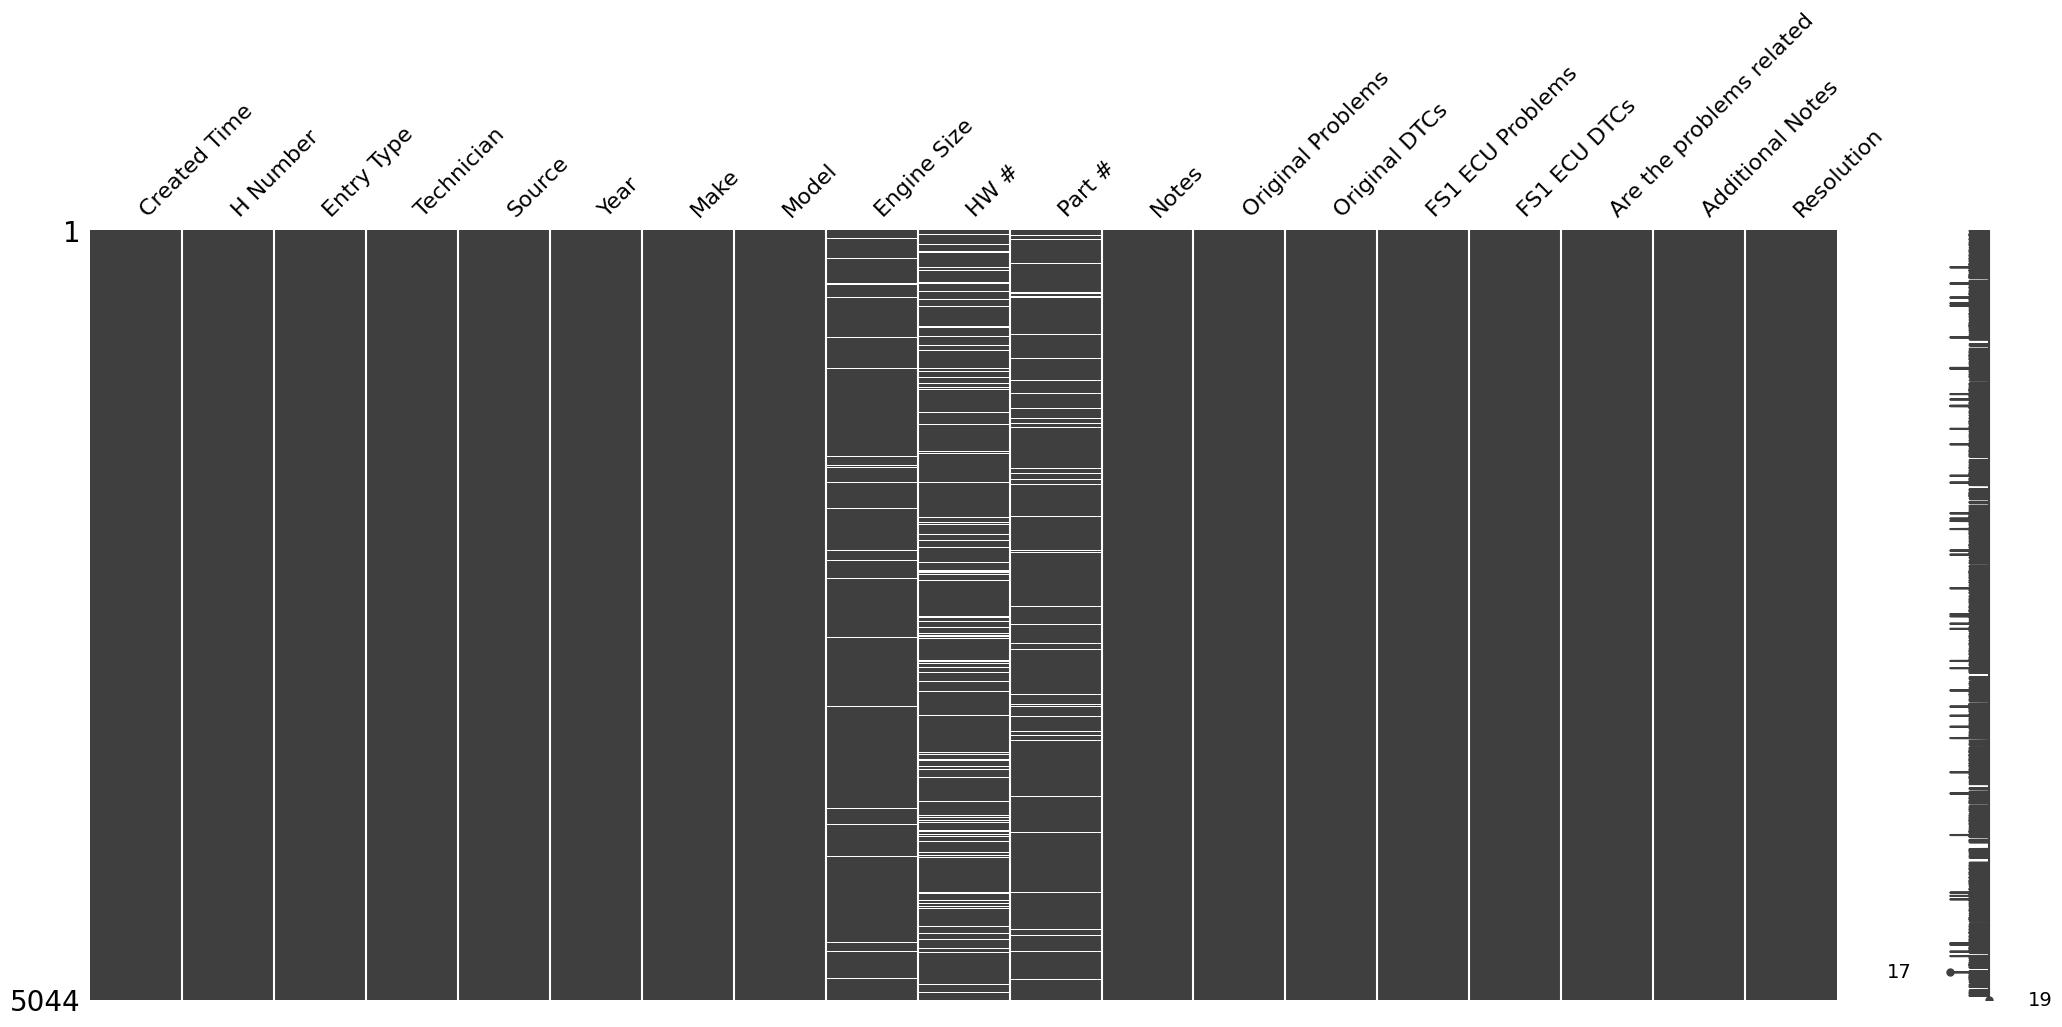

In [100]:
# Visualize the missing values on the new dataframe chart
msno.matrix(df_zoho_form_dropped_column)

In [101]:
# Check the columns
df_zoho_form_dropped_column.columns

Index(['Created Time', 'H Number', 'Entry Type', 'Technician', 'Source',
       'Year', 'Make', 'Model', 'Engine Size', 'HW #', 'Part #', 'Notes',
       'Original Problems', 'Original DTCs', 'FS1 ECU Problems',
       'FS1 ECU DTCs', 'Are the problems related', 'Additional Notes',
       'Resolution'],
      dtype='object')

In [102]:
# Rename the column 'Are the problems related' to 'Orig. FS1 Problems Related'
df_zoho_form_final_version = df_zoho_form_dropped_column.rename(columns={'Are the problems related': 'Orig. FS1 Problems Related'})

In [103]:
# Check the info
df_zoho_form_final_version.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5044 entries, 13 to 8394
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Created Time                5044 non-null   object 
 1   H Number                    5044 non-null   object 
 2   Entry Type                  5044 non-null   object 
 3   Technician                  5044 non-null   object 
 4   Source                      5044 non-null   object 
 5   Year                        5044 non-null   float64
 6   Make                        5044 non-null   object 
 7   Model                       5043 non-null   object 
 8   Engine Size                 4902 non-null   object 
 9   HW #                        4472 non-null   object 
 10  Part #                      4789 non-null   object 
 11  Notes                       5044 non-null   object 
 12  Original Problems           5044 non-null   object 
 13  Original DTCs               5044 non-

In [104]:
# Drop column notes
df_zoho_form_final_version_drop_col = df_zoho_form_final_version.drop(columns=['Notes'])

In [107]:
# Save the cleaned dataframe to a .csv file
df_zoho_form_final_version_drop_col.to_csv('C:\Language_Projects\Language_Projects\Python\Flagship_1\\automotive_diagnostic_data_cleaning\data\data_cleaned\df_zoho_form_cleaned.csv', index=False)

<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:2: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Weverson Barbieri\AppData\Local\Temp\ipykernel_10624\1980170013.py:2: SyntaxWarning: invalid escape sequence '\L'
  df_zoho_form_final_version_drop_col.to_csv('C:\Language_Projects\Language_Projects\Python\Flagship_1\\automotive_diagnostic_data_cleaning\data\data_cleaned\df_zoho_form_cleaned.csv', index=False)
